# **Partie I : Implémenter un réseau LSTM pour l'analyse de sentiment à l'aide d'un ensemble de donnéesau format CSV.**

#  Préparation de l’environnement du travail

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM
import csv
import string
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.layers import Activation

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Chargement et Exploration du Jeu de Données

In [ ]:
df=pd.read_csv("IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# Display basic information about the dataset
print("Summary of the dataset:")
print(df.info())

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(df.head())

Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

First few rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
positive_count = df['sentiment'].value_counts()['positive']
negative_count = df['sentiment'].value_counts()['negative']

print(f"Number of positive reviews: {positive_count}")
print(f"Number of negative reviews: {negative_count}")


Number of positive reviews: 25000
Number of negative reviews: 25000


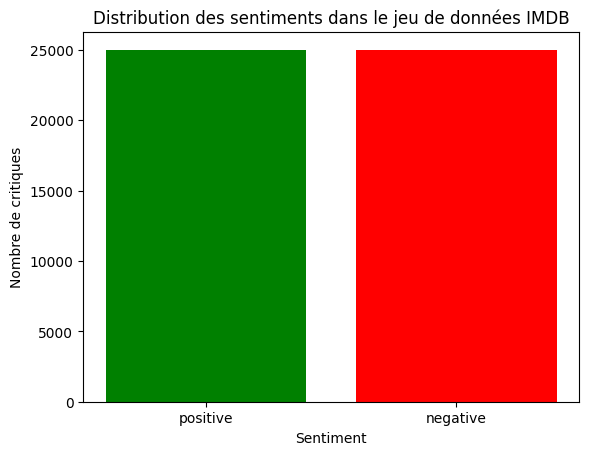

In [ ]:
# Compter le nombre de sentiments positifs et négatifs
sentiment_counts = df['sentiment'].value_counts()

# Tracer le diagramme à barres
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Nombre de critiques')
plt.title('Distribution des sentiments dans le jeu de données IMDB')
plt.show()


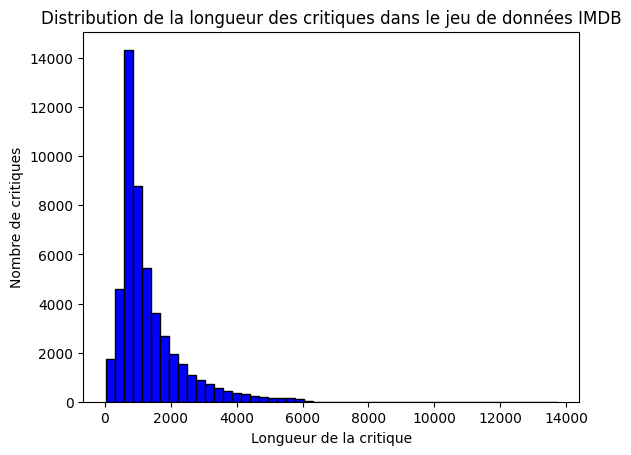

In [ ]:
# Ajouter une colonne pour la longueur des critiques
df['review_length'] = df['review'].apply(len)

# Tracer l'histogramme
plt.hist(df['review_length'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Longueur de la critique')
plt.ylabel('Nombre de critiques')
plt.title('Distribution de la longueur des critiques dans le jeu de données IMDB')
plt.show()

# Pre-processing


In [ ]:
#  Suppression de la Ponctuation
df['without_punctuation'] = df['review'].apply(lambda x: ''.join([word for word in x if word not in string.punctuation]))
df['without_punctuation']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production br br The filmin...
2        I thought this was a wonderful way to spend ti...
3        Basically theres a family where a little boy J...
4        Petter Matteis Love in the Time of Money is a ...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot bad dialogue bad acting idiotic direc...
49997    I am a Catholic taught in parochial elementary...
49998    Im going to have to disagree with the previous...
49999    No one expects the Star Trek movies to be high...
Name: without_punctuation, Length: 50000, dtype: object

In [ ]:
#Transformation en Minuscules
df['lowercase'] = df['without_punctuation'].apply(lambda x: x.lower())
df['lowercase']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production br br the filmin...
2        i thought this was a wonderful way to spend ti...
3        basically theres a family where a little boy j...
4        petter matteis love in the time of money is a ...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    im going to have to disagree with the previous...
49999    no one expects the star trek movies to be high...
Name: lowercase, Length: 50000, dtype: object

In [ ]:
#Suppression des mots vides
stop_words = set(stopwords.words('english'))
df['without_stopwords'] = df['lowercase'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df['without_stopwords']

0        one reviewers mentioned watching 1 oz episode ...
1        wonderful little production br br filming tech...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    im going disagree previous comment side maltin...
49999    one expects star trek movies high art fans exp...
Name: without_stopwords, Length: 50000, dtype: object

## Tokeniser & Convert text to sequences of integers avec une longueur de séquence nominale de 200

In [ ]:
# Separate features (X) and labels (y)
X = df['without_stopwords']
y = df['sentiment']
# Initialize a Tokenizer
tokenizer = Tokenizer(num_words=10000)

# Fit the tokenizer on the entire text data
tokenizer.fit_on_texts(X)

# Convert text to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X)

# Specify a maximum sequence length
max_length = 200

# Pad sequences to the specified length
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')
# Initialize a LabelEncoder to convert labels to numerical format
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded , test_size=0.2, random_state=42)

# Construction du Modèle RNN basique

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the vocabulary size and sequence length
vocab_size = 10000
sequence_length = 200

# Create the Sequential model
model = Sequential()

# Add an Embedding layer
embedding_dim = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Add an LSTM layer
lstm_units = 32
model.add(LSTM(units=lstm_units))

# Add a Dense layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 32)           320000    
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compilation et Entraînement du Modèle

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 42s 151ms/step - loss: 0.6917 - accuracy: 0.5117 - val_loss: 0.6868 - val_accuracy: 0.5455
Epoch 2/10
250/250 [==============================] - 37s 148ms/step - loss: 0.6562 - accuracy: 0.5801 - val_loss: 0.5599 - val_accuracy: 0.7729
Epoch 3/10
250/250 [==============================] - 35s 141ms/step - loss: 0.6837 - accuracy: 0.5470 - val_loss: 0.6885 - val_accuracy: 0.5138
Epoch 4/10
250/250 [==============================] - 35s 142ms/step - loss: 0.6830 - accuracy: 0.5308 - val_loss: 0.6849 - val_accuracy: 0.5185
Epoch 5/10
250/250 [==============================] - 50s 202ms/step - loss: 0.6706 - accuracy: 0.5433 - val_loss: 0.6748 - val_accuracy: 0.5276
Epoch 6/10
250/250 [==============================] - 44s 177ms/step - loss: 0.6483 - accuracy: 0.5933 - val_loss: 0.6787 - val_accuracy: 0.5325
Epoch 7/10
250/250 [==============================] - 50s 199ms/step - loss: 0.6559 - accuracy: 0.5855 - val_loss: 0.6890 - val_ac

#  Évaluation du Modèle

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
precision = precision_score(y_test, y_pred_binary)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

313/313 [==============================] - 7s 20ms/step
Test Loss: 0.4569
Test Accuracy: 0.8274
Precision: 0.8280


The accuracy is relatively high.
Precision of 79.31% suggests that when the model predicts a positive instance, it tends to be correct.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))


Confusion Matrix:
[[4092  869]
 [ 857 4182]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4961
           1       0.83      0.83      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



#  Analyse des Paramètres du Modèle

## Modifiez le nombre d'unités dans le RNN

In [ ]:
# Define the vocabulary size and sequence length
vocab_size = 10000
sequence_length = 200

# Create the Sequential model
model = Sequential()

# Add an Embedding layer
embedding_dim = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Add an LSTM layer
lstm_units = 40
model.add(LSTM(units=lstm_units))

# Add a Dense layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           320000    
                                                                 
 lstm_1 (LSTM)               (None, 40)                11680     
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 331721 (1.27 MB)
Trainable params: 331721 (1.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 45s 169ms/step - loss: 0.6914 - accuracy: 0.5129 - val_loss: 0.6869 - val_accuracy: 0.5236
Epoch 2/10
250/250 [==============================] - 41s 166ms/step - loss: 0.6674 - accuracy: 0.5528 - val_loss: 0.5376 - val_accuracy: 0.7596
Epoch 3/10
250/250 [==============================] - 39s 156ms/step - loss: 0.5834 - accuracy: 0.7364 - val_loss: 0.5889 - val_accuracy: 0.7084
Epoch 4/10
250/250 [==============================] - 44s 176ms/step - loss: 0.5688 - accuracy: 0.7123 - val_loss: 0.5815 - val_accuracy: 0.7150
Epoch 5/10
250/250 [==============================] - 47s 187ms/step - loss: 0.6125 - accuracy: 0.6424 - val_loss: 0.5799 - val_accuracy: 0.6990
Epoch 6/10
250/250 [==============================] - 44s 176ms/step - loss: 0.5825 - accuracy: 0.7030 - val_loss: 0.6821 - val_accuracy: 0.5185
Epoch 7/10
250/250 [==============================] - 43s 173ms/step - loss: 0.6524 - accuracy: 0.5521 - val_loss: 0.6766 - val_ac

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

313/313 [==============================] - 9s 27ms/step
Confusion Matrix:
[[4795  166]
 [4481  558]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.97      0.67      4961
           1       0.77      0.11      0.19      5039

    accuracy                           0.54     10000
   macro avg       0.64      0.54      0.43     10000
weighted avg       0.64      0.54      0.43     10000



performance a diminuer avec 40 unite

## Utilisez un autre type de fonction d'activation

In [ ]:
# Define the vocabulary size and sequence length
vocab_size = 10000
sequence_length = 200

# Create the Sequential model
model = Sequential()

# Add an Embedding layer
embedding_dim = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Add an LSTM layer
lstm_units = 32
model.add(LSTM(units=lstm_units,activation='tanh'))

# Add a Dense layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 32)           320000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 44s 168ms/step - loss: 0.6918 - accuracy: 0.5207 - val_loss: 0.6885 - val_accuracy: 0.5295
Epoch 2/10
250/250 [==============================] - 35s 140ms/step - loss: 0.6057 - accuracy: 0.6881 - val_loss: 0.5592 - val_accuracy: 0.7253
Epoch 3/10
250/250 [==============================] - 39s 156ms/step - loss: 0.5361 - accuracy: 0.7645 - val_loss: 0.5515 - val_accuracy: 0.7545
Epoch 4/10
250/250 [==============================] - 42s 167ms/step - loss: 0.5228 - accuracy: 0.7762 - val_loss: 0.5352 - val_accuracy: 0.7694
Epoch 5/10
250/250 [==============================] - 35s 141ms/step - loss: 0.6146 - accuracy: 0.6732 - val_loss: 0.5369 - val_accuracy: 0.7605
Epoch 6/10
250/250 [==============================] - 33s 133ms/step - loss: 0.5034 - accuracy: 0.7865 - val_loss: 0.5191 - val_accuracy: 0.7797
Epoch 7/10
250/250 [==============================] - 35s 140ms/step - loss: 0.4869 - accuracy: 0.7947 - val_loss: 0.5135 - val_ac

Epoch 1/10
250/250 [==============================] - 36s 145ms/step - loss: 0.5433 - accuracy: 0.7590 - val_loss: 0.5738 - val_accuracy: 0.7306
Epoch 2/10
250/250 [==============================] - 35s 140ms/step - loss: 0.5847 - accuracy: 0.7022 - val_loss: 0.6856 - val_accuracy: 0.5161
Epoch 3/10
250/250 [==============================] - 46s 184ms/step - loss: 0.6704 - accuracy: 0.5462 - val_loss: 0.6801 - val_accuracy: 0.5268
Epoch 4/10
250/250 [==============================] - 40s 159ms/step - loss: 0.6544 - accuracy: 0.5541 - val_loss: 0.6717 - val_accuracy: 0.5421
Epoch 5/10
250/250 [==============================] - 36s 142ms/step - loss: 0.6571 - accuracy: 0.5805 - val_loss: 0.6652 - val_accuracy: 0.5346
Epoch 6/10
250/250 [==============================] - 36s 143ms/step - loss: 0.6620 - accuracy: 0.5698 - val_loss: 0.6624 - val_accuracy: 0.5726
Epoch 7/10
250/250 [==============================] - 33s 131ms/step - loss: 0.4753 - accuracy: 0.8129 - val_loss: 0.5392 - val_ac

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))


313/313 [==============================] - 7s 20ms/step
Confusion Matrix:
[[3251 1710]
 [ 764 4275]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.66      0.72      4961
           1       0.71      0.85      0.78      5039

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



# **Partie II : Implémenter un réseau Bi-LSTM pour l'analyse de sentiment à l'aide d'un ensemble de données au format CS**

# Préparation de l’environnement du travail


In [ ]:
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, Bidirectional

# Construction du Modèle Bi-LSTM basique

In [ ]:
vocab_size = 10000
sequence_length = 200
# Create the Sequential model
model = Sequential()

# Add an Embedding layer
embedding_dim = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Add a Bidirectional LSTM layer
lstm_units = 32
model.add(Bidirectional(LSTM(units=lstm_units)))

# Add a Dense layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 32)           320000    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336705 (1.28 MB)
Trainable params: 336705 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compilation et Entraînement du Modèle

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 81s 310ms/step - loss: 0.4674 - accuracy: 0.7719 - val_loss: 0.2969 - val_accuracy: 0.8809
Epoch 2/10
250/250 [==============================] - 76s 306ms/step - loss: 0.2392 - accuracy: 0.9094 - val_loss: 0.2849 - val_accuracy: 0.8817
Epoch 3/10
250/250 [==============================] - 70s 282ms/step - loss: 0.1846 - accuracy: 0.9341 - val_loss: 0.3160 - val_accuracy: 0.8873
Epoch 4/10
250/250 [==============================] - 61s 244ms/step - loss: 0.1559 - accuracy: 0.9458 - val_loss: 0.3177 - val_accuracy: 0.8788
Epoch 5/10
250/250 [==============================] - 61s 244ms/step - loss: 0.1232 - accuracy: 0.9596 - val_loss: 0.3694 - val_accuracy: 0.8774
Epoch 6/10
250/250 [==============================] - 66s 263ms/step - loss: 0.1028 - accuracy: 0.9672 - val_loss: 0.3756 - val_accuracy: 0.8646
Epoch 7/10
250/250 [==============================] - 69s 277ms/step - loss: 0.0922 - accuracy: 0.9716 - val_loss: 0.4610 - val_ac

# Évaluation du Modèle

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

313/313 [==============================] - 14s 41ms/step
Confusion Matrix:
[[4310  651]
 [ 659 4380]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4961
           1       0.87      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



#  Analyse des Paramètres du Modèle

## Modifiez le nombre d'unités dans le Bi-LSTM

In [ ]:
vocab_size = 10000
sequence_length = 200
# Create the Sequential model
model = Sequential()

# Add an Embedding layer
embedding_dim = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Add a Bidirectional LSTM layer
lstm_units = 20
model.add(Bidirectional(LSTM(units=lstm_units)))

# Add a Dense layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 32)           320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                8480      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
Total params: 328521 (1.25 MB)
Trainable params: 328521 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 56s 207ms/step - loss: 0.4548 - accuracy: 0.7909 - val_loss: 0.3066 - val_accuracy: 0.8784
Epoch 2/10
250/250 [==============================] - 48s 193ms/step - 

## Utilisez un autre type de fonction d'activation

In [ ]:
vocab_size = 10000
sequence_length = 200
# Create the Sequential model
model = Sequential()

# Add an Embedding layer
embedding_dim = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Add a Bidirectional LSTM layer
lstm_units = 32
model.add(Bidirectional(LSTM(units=lstm_units,activation='tanh')))

# Add a Dense layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 32)           320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336705 (1.28 MB)
Trainable params: 336705 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 68s 253ms/step - loss: 0.5106 - accuracy: 0.7548 - val_loss: 0.3428 - val_accuracy: 0.8635
Epoch 2/10
250/250 [==============================] - 60s 238ms/step - 

Diminution de performance